In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Long Short Term Memory
![LSTM](data/LSTM3-chain.png "LSTM")

输入门 it：控制有多少信息可以流入memory cell。

遗忘门 ft：控制有多少上一时刻的memory cell中的信息可以累积到当前时刻的memory cell中。

输出门 ot：控制有多少当前时刻的memory cell中的信息可以流入当前隐藏状态 ht中。

In [2]:
class LSTMcell(object):
    def __init__(self, incoming, D_input, D_cell, weight_initializer, f_bias=1.0,
                 L2=False, h_act=tf.tanh, hidden_init=None, cell_init=None):
#         """
#         :param incoming: used for accepting input data, shape=[n_steps, n_samples, D_input]
#         :param D_input: scalar, dim of input
#         :param D_cell: scalar, dim of hidden state and memory cell
#         :param weight_initializer: function for initializing weight params
#         :param f_bias: scalar, bias for forget gate
#         :param L2: bool
#         :param h_act: activication function for hidden state
#         :param hidden_init: initial hidden state
#         :param cell_init: initial cell state
#         """

        self.incoming = incoming
        self.D_input = D_input
        self.D_cell = D_cell
        self.weight_initializer = weight_initializer
        self.f_bias = f_bias
        self.h_act = h_act
        self.cell_init = cell_init
        self.hidden_init = hidden_init
        self.type = 'lstm'

        if hidden_init is None and cell_init is None:
            init_for_both = tf.matmul(self.incoming[0,:,:], tf.zeros([D_input, D_cell]))
            self.cell_init = init_for_both
            self.hidden_init = init_for_both
        self.previous = tf.stack([self.hidden_init, self.cell_init], axis=0)

        # init params for forget gate layer
        self.fgate = self.Gate(f_bias)

        # init params for input gate layer
        self.igate = self.Gate()
        # init params for cell state
        self.cgate = self.Gate()

        # init params for output gate layer
        self.ogate = self.Gate()

        self.W_x = tf.concat([self.fgate[0], self.igate[0], self.cgate[0], self.ogate[0]], axis=1);    #shape = [D_input, 4*D_cell]
        self.W_h = tf.concat([self.fgate[1], self.igate[1], self.cgate[1], self.ogate[1]], axis=1);    #shape = [D_cell, 4*D_cell]
        self.b = tf.concat([self.fgate[2], self.igate[2], self.cgate[2], self.ogate[2]], axis=0);    #shape=[4*D_cell]

        if L2:
            self.L2_loss = tf.nn.l2_loss(self.W_x) + tf.nn.l2_loss(self.W_h)

    def Gate(self, bias = 0.001):
        Wx = self.weight_initializer([self.D_input, self.D_cell])
        Wh = self.weight_initializer([self.D_cell, self.D_cell])
        b = tf.Variable(tf.constant(bias, shape=[self.D_cell]), trainable=True)
        return Wx, Wh, b

    def Slice(self, x, n):
        return x[:, n*self.D_cell:(n+1)*self.D_cell]

    def Step(self, previous_h_c_tuple, current_x):
#         """
#         :param previous_h_c_tuple: tuple of (previous_hidden_state, previous_cell_state)
#         :param current_x: current input
#         :return: tuple of (current_hidden_state, current_cell_state)
#         """
        prev_hidden, prev_cell = tf.unstack(previous_h_c_tuple)

        # cal all gates
        gates = tf.matmul(current_x, self.W_x) + tf.matmul(prev_hidden, self.W_h) + self.b
        # cal forget gate
        f = tf.sigmoid(self.Slice(gates, 0))
        # cal input gate
        i = tf.sigmoid(self.Slice(gates, 1))
        # cal current cell
        c = tf.tanh(self.Slice(gates, 2))
        cur_cell = prev_hidden*f + i*c
        # cal current hidden
        o = tf.sigmoid(self.Slice(gates, 3))
        cur_hidden = tf.tanh(cur_cell)*o

        return tf.stack([cur_hidden, cur_cell])

## Gated Recurrent Unit
![GRU](data/LSTM3-var-GRU.png "GRU")

In [3]:
class GRUcell(object):
    def __init__(self, incoming, D_input, D_cell, weight_initializer, L2=False, hidden_init=None):
#         """
#         :param incoming: used for accepting input data, shape=[n_steps, n_samples,D_input]
#         :param D_input: scalar, dim of input
#         :param D_cell: scalar, dim of hidden state and memory cell
#         :param weight_initializer: function for initializing weight params
#         :param L2: bool
#         :param hidden_init: initial hidden state
#         """
        self.incoming = incoming
        self.D_input = D_input
        self.D_cell = D_cell
        self.weight_initializer = weight_initializer
        self.hidden_init = hidden_init
        self.type = 'gru'

        if hidden_init is None :
            self.hidden_init = tf.matmul(self.incoming[0,:,:], tf.zeros([D_input, D_cell]))
        self.previous = self.hidden_init

        # init params for reset gate layer
        self.rgate = self.Gate()

        # init params for update gate layer
        self.ugate = self.Gate()
        # init params for cell state
        self.cgate = self.Gate()

        self.W_x = tf.concat([self.rgate[0], self.ugate[0], self.cgate[0]], axis=1);    #shape = [D_input, 4*D_cell]
        self.W_h = tf.concat([self.rgate[1], self.ugate[1], self.cgate[1]], axis=1);    #shape = [D_cell, 4*D_cell]
        self.b = tf.concat([self.rgate[2], self.ugate[2], self.cgate[2]], axis=0);    #shape=[4*D_cell]

        if L2:
            self.L2_loss = tf.nn.l2_loss(self.W_x) + tf.nn.l2_loss(self.W_h)

    def Gate(self, bias = 0.001):
        Wx = self.weight_initializer([self.D_input, self.D_cell])
        Wh = self.weight_initializer([self.D_cell, self.D_cell])
        b = tf.Variable(tf.constant(bias, shape=[self.D_cell]), trainable=True)
        return Wx, Wh, b

    def Slice(self, x, n):
        return x[:, n*self.D_cell:(n+1)*self.D_cell]

    def Step(self, previous_h, current_x):
#         """
#         :param previous_h: previous_hidden_state
#         :param current_x: current input
#         :return:current_hidden_state
#         """

        W_x = tf.matmul(current_x, self.W_x) + self.b
        W_h = tf.matmul(previous_h, self.W_h) 
        # cal reset gate
        r = tf.sigmoid(self.Slice(W_x, 0) + self.Slice(W_h, 0))
        # cal update gate
        u = tf.sigmoid(self.Slice(W_x, 1) + self.Slice(W_h, 1))
        c = tf.tanh(self.Slice(W_x, 2) + r*self.Slice(W_h, 2))
        # cal current hidden
        current_h = u*c + (1-u)*previous_h

        return current_h

In [4]:
def RNN(cell_f, cell_b=None, merge='sum'):
#         """
#         :param cell_f: forward rnn cell
#         :param cell_b: backword rnn cell
#         :param merge:
#         :return: hidden_states
#         """
    # forward rnn loop
    hidden_states = tf.scan(fn=cell_f.Step, elems=cell_f.incoming, 
                                initializer=cell_f.previous, name="hidden_states")
    # Args:
    # fn: function, accepts two arguments, 
    #     first one is the output of the previous step of calling 'fn'
    #     second one is the current input unpack from 'elems' on dim 0
    # elems: a list of tensors. shape=[n_steps, n_samples, D_input]
    # initializer: intial values for the first argument in 'fn'
    # Return:
    # shape=[n_steps,2, n_samples, D_cell], 
    # the second dimension 2 composes of hidden state and memory cell
    if cell_f.type=='lstm':  
        hidden_states = hidden_states[:,0,:,:]    #shape=[n_steps, n_samples, D_cell]
    
    # backword rnn loop
    if cell_b is not None:
        incoming_b = tf.reverse(cell_b.incoming, axis=[0])
        hidden_states_b = tf.scan(fn=cell_b.Step, elems=incoming_b, 
                                initializer=cell_b.previous, name="hidden_states_b")
        if cell_b.type=='lstm':  
            hidden_states_b = hidden_states_b[:,0,:,:]
        hidden_states_b = tf.reverse(hidden_states_b, axis=[0])
        
        if merge=='sum':
            hidden_states = hidden_states + hidden_states_b
        else:
            hidden_states = tf.concat([hidden_states, hidden_states_b], axis =2)
        
    return hidden_states

In [5]:
def weight_init(shape):
    initial = tf.random_uniform(shape=shape, 
                                minval=-np.sqrt(5)*np.sqrt(1.0/shape[0]), 
                                maxval=np.sqrt(5)*np.sqrt(1.0/shape[0]))
    return tf.Variable(initial, trainable=True)

def zero_init(shape):
    return tf.Variable(tf.zeros(shape), trainable=True)

def orthogonal_initializer(shape,scale = 1.0):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
    scale = 1.0
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape) #this needs to be corrected to float32
    return tf.Variable(scale * q[:shape[0], :shape[1]],trainable=True, dtype=tf.float32)

def bias_init(shape):
    return tf.Variable(tf.constant(0.01, shape=shape))

In [6]:
import utils
data = utils.loadXY()
n_samples = len(data)
split_size=0.8
train_data=data[:int(n_samples*split_size)]
test_data=data[int(n_samples*split_size):]
print("Num of train samples: {}".format(len(train_data)))
print("Num of test samples: {}".format(len(test_data)))

loading data ......
Samples: 103
Input shape: (886, 39)
Labels shape: (886, 24)
Standardizing ......
Num of train samples: 82
Num of test samples: 21


![RNN](data/FULLBRNN.jpg "RNN")

In [7]:
D_input = 39
D_label = 24
learning_rate = 7e-5
num_units = 256
L2_penalty = 1e-4

inputs_ = tf.placeholder(shape=[None, None, D_input], dtype=tf.float32, name="inputs")
labels_ = tf.placeholder(shape=[None, D_label], dtype=tf.float32, name="labels")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

n_steps = tf.shape(inputs_)[1]
n_samples = tf.shape(inputs_)[0]

layer0 = tf.reshape(inputs_, [-1, D_input])

Wf1 = weight_init([D_input, num_units])
bf1 = bias_init([num_units])
layer1 = tf.nn.relu(tf.matmul(layer0, Wf1) + bf1)
layer1 = tf.nn.dropout(layer1, keep_prob=keep_prob)

Wf2 = weight_init([num_units, num_units])
bf2 = bias_init([num_units])
layer2 = tf.nn.relu(tf.matmul(layer1, Wf2) + bf2)
layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)

incoming = tf.reshape(layer2, [n_samples, n_steps, num_units])
# change the shape of incoming to [n_steps, n_samples, D_input] for tf.scan
incoming = tf.transpose(incoming, perm=[1,0,2])

rnn_fcell = GRUcell(incoming, num_units, num_units, orthogonal_initializer)
rnn_bcell = GRUcell(incoming, num_units, num_units, orthogonal_initializer)
rnn0 = RNN(rnn_fcell, None)
layer3 = tf.reshape(rnn0, [-1, num_units])
layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)

Wf4 = weight_init([num_units, num_units])
bf4 = bias_init([num_units])
layer4 = tf.nn.relu(tf.matmul(layer3, Wf4) + bf4)
layer4 = tf.nn.dropout(layer3, keep_prob=keep_prob)

Wf5 = weight_init([num_units, num_units])
bf5 = bias_init([num_units])
layer5 = tf.nn.relu(tf.matmul(layer4, Wf5) + bf5)
layer5 = tf.nn.dropout(layer4, keep_prob=keep_prob)

Wo = weight_init([num_units, D_label])
bo = bias_init([D_label])
output = tf.matmul(layer5, Wo) + bo

loss=tf.reduce_mean((output-labels_)**2)
L2 = tf.nn.l2_loss(Wf1) + tf.nn.l2_loss(Wf2)+ tf.nn.l2_loss(Wf4) + \
          tf.nn.l2_loss(Wf5) + tf.nn.l2_loss(Wo)
    #+ rnn_fcell.L2_loss + rnn_bcell.L2_loss 

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss+L2_penalty*L2)

In [8]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
epoches=50
for e in range(epoches):
    train_data_e = utils.shuffle_list(train_data)
    train_costs=[]
    test_costs=[]
    for i in range(len(train_data_e)):
        cost, _ = sess.run([loss,optimizer], 
                                   feed_dict={inputs_:train_data_e[i][0], labels_:train_data_e[i][1], keep_prob:0.75})
        train_costs.append(cost)
    for i in range(len(test_data)):
        cost = sess.run(loss,feed_dict={inputs_:test_data[i][0], labels_:test_data[i][1], keep_prob:1.0})
        test_costs.append(cost)
    print("Epoch {}: train_cost = {:.4f}, test_cost = {:.4f}".format(e+1, np.mean(train_costs), np.mean(test_costs)))

Epoch 1: train_cost = 1.6308, test_cost = 0.9520
Epoch 2: train_cost = 1.2768, test_cost = 0.8452
Epoch 3: train_cost = 1.1184, test_cost = 0.7879
Epoch 4: train_cost = 1.0236, test_cost = 0.7506
Epoch 5: train_cost = 0.9610, test_cost = 0.7214
Epoch 6: train_cost = 0.9106, test_cost = 0.6965
Epoch 7: train_cost = 0.8674, test_cost = 0.6784
Epoch 8: train_cost = 0.8350, test_cost = 0.6643
Epoch 9: train_cost = 0.8058, test_cost = 0.6471
Epoch 10: train_cost = 0.7816, test_cost = 0.6407
Epoch 11: train_cost = 0.7610, test_cost = 0.6302
Epoch 12: train_cost = 0.7365, test_cost = 0.6158
Epoch 13: train_cost = 0.7204, test_cost = 0.6076
Epoch 14: train_cost = 0.7064, test_cost = 0.6019
Epoch 15: train_cost = 0.6853, test_cost = 0.5927
Epoch 16: train_cost = 0.6786, test_cost = 0.5884
Epoch 17: train_cost = 0.6605, test_cost = 0.5807
Epoch 18: train_cost = 0.6477, test_cost = 0.5741
Epoch 19: train_cost = 0.6356, test_cost = 0.5718
Epoch 20: train_cost = 0.6250, test_cost = 0.5652
Epoch 21:

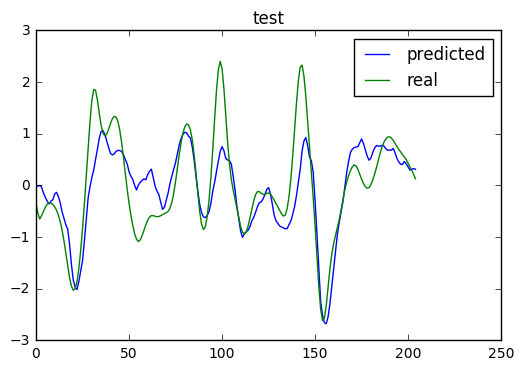

In [10]:
pY = sess.run(output, feed_dict={inputs_:test_data[10][0], keep_prob:1.0})
plt.plot(pY[:,8])
plt.plot(test_data[10][1][:,8])
plt.title('test')
plt.legend(['predicted','real'])
plt.show()

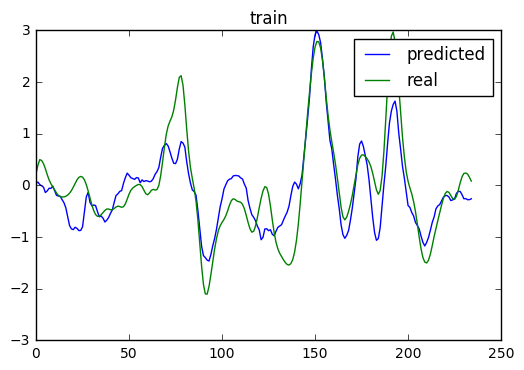

In [11]:
pY = sess.run(output, feed_dict={inputs_:train_data[10][0], keep_prob:1.0})
plt.plot(pY[:,8])
plt.plot(train_data[10][1][:,8])
plt.title('train')
plt.legend(['predicted','real'])
plt.show()